# Imports

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Data setup 

In [97]:
X = np.load("data/X-data.npy")
y = np.load("data/y-data.npy")

In [98]:
X = X.reshape(len(X), X.shape[1], 1)

# Class definitions

In [99]:
class Layer():  # Abstract class for layers
    def __init__(self):
        self.input = None
        self.output = None
        
    def forward(self, input):
        pass
    
    def backward(self, output, learning_rate):
        pass

In [100]:
class Activation():
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [101]:
class ReLU(Activation):
    def __init__(self):
        def relu(x):
            return np.maximum(0,x)

        def relu_prime(x):
            return (x > 0) * 1

        super().__init__(relu, relu_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

In [102]:
class Dense(Layer):
    def __init__(self, input_size, output_size, activation_function='relu'):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)
        if activation_function == 'relu':
            self.activation_function = ReLU()
        elif activation_function == 'sigmoid':
            self.activation_function = Sigmoid()
        else:  # default to relu
            self.activation_function = ReLU()

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

# Helper functions

In [103]:
def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

In [104]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

# Why does this only work in a function? 
error_viz = []
def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        error_viz.append(error)

# Training

#### Constants 

In [105]:
input_shape = X.shape[1]
learning_rate = 0.01
epochs = 100

In [106]:
network = [
    Dense(input_shape, 10, activation_function='relu'),
    Dense(10, 1, activation_function='sigmoid'),
    Sigmoid()
]

train(network, binary_cross_entropy, binary_cross_entropy_prime, X, y, epochs, learning_rate)

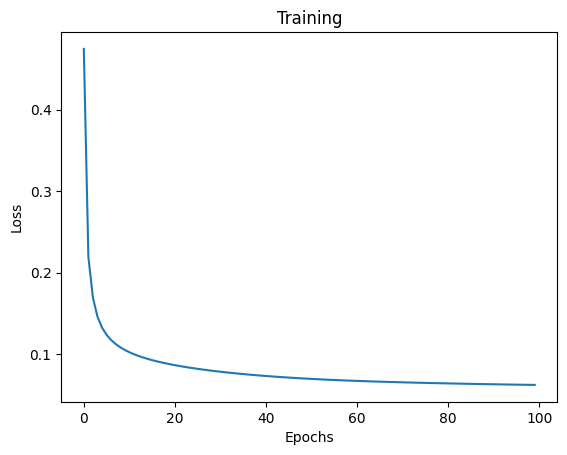

In [107]:
plt.plot(error_viz)
plt.title("Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Evaluation 

In [108]:
pred = []
for i in X:
    pred.append(predict(network, i))

In [109]:
res = pd.DataFrame()
res["predictions"] = pred
res["actual"] = y

In [110]:
res["predictions"] = res["predictions"].apply(lambda x: x[0][0])
res["predictions"] = res["predictions"].apply(lambda x: 0 if x < 0.5 else 1)
res

,predictions,actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
564,0,0
565,0,0
566,0,0
567,0,0


In [111]:
print("Accuracy:",(len(res["predictions"] == res["actual"]) / len(X) * 100))

Accuracy: 100.0
